✅ Parsed 8 input vectors (latest batch only).
✅ Parsed 8 outputs (latest batch only).

=== Function 1 (2D) ===
  Data size: 17, Output range: [-0.0036, 64.0000]


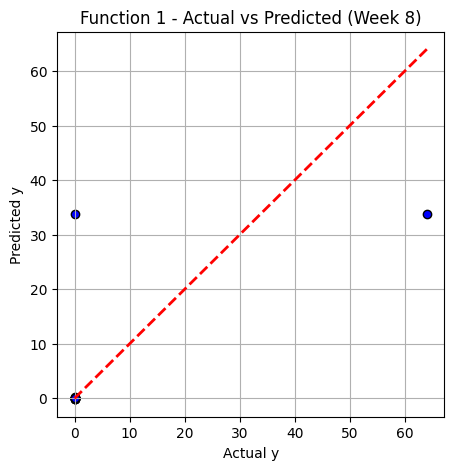

  Best predicted output: 49.8727
  Query to submit: 0.193087-0.534120

=== Function 2 (2D) ===
  Data size: 17, Output range: [-0.0656, 3.1124]


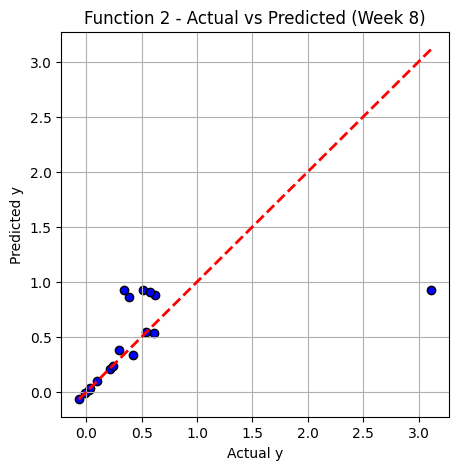

  Best predicted output: 0.9303
  Query to submit: 0.741771-0.714764

=== Function 3 (3D) ===
  Data size: 22, Output range: [-0.3989, 71.0000]


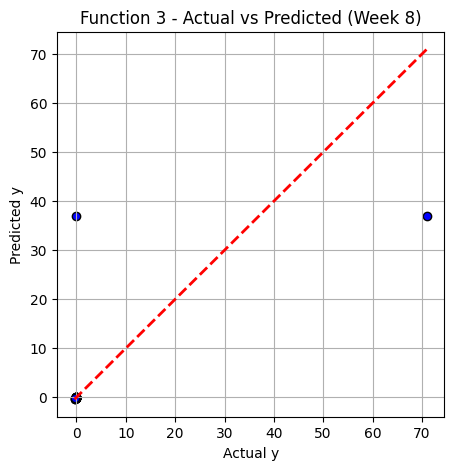

  Best predicted output: 46.1695
  Query to submit: 0.220011-0.672529-0.760436

=== Function 4 (4D) ===
  Data size: 37, Output range: [-32.6257, 64.0000]


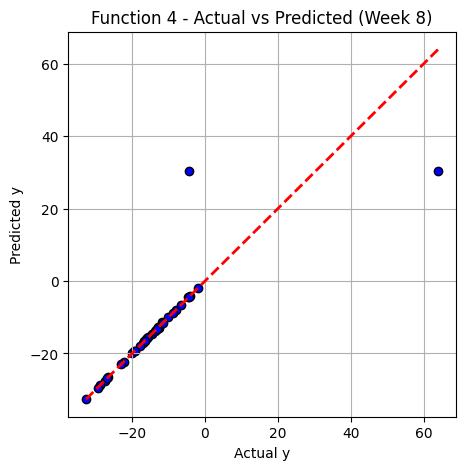

  Best predicted output: 26.2758
  Query to submit: 0.222811-0.292575-0.273637-0.371506

=== Function 5 (4D) ===
  Data size: 27, Output range: [0.1129, 3042.5479]


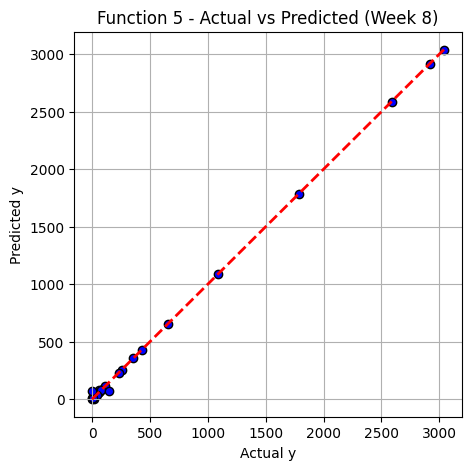

  Best predicted output: 3587.6527
  Query to submit: 0.000000-1.000000-1.000000-1.000000

=== Function 6 (5D) ===
  Data size: 27, Output range: [-2.5712, 64.0000]


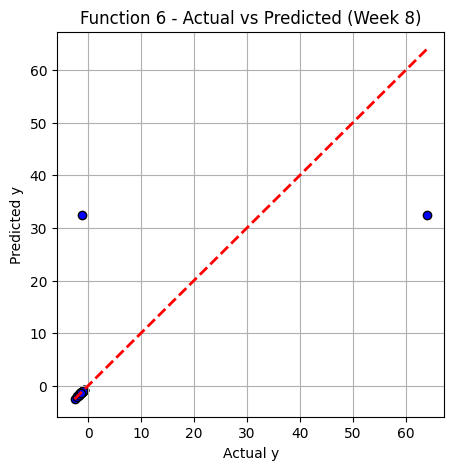

  Best predicted output: 35.5806
  Query to submit: 0.418622-0.286717-0.000000-0.828069-0.290010

=== Function 7 (6D) ===
  Data size: 37, Output range: [-0.0787, 2.0091]


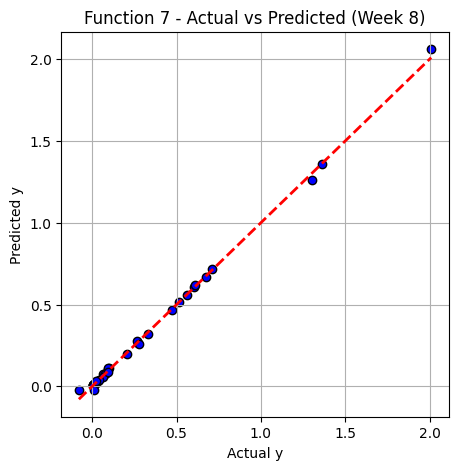

  Best predicted output: 2.6180
  Query to submit: 0.011830-0.264752-0.000000-0.081262-0.412307-0.707882

=== Function 8 (8D) ===
  Data size: 47, Output range: [5.5922, 64.0000]


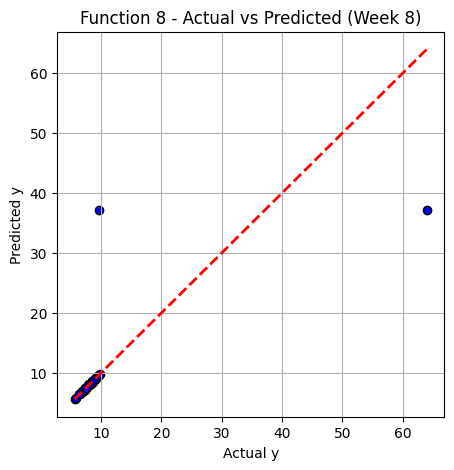

  Best predicted output: 44.4853
  Query to submit: 0.000000-0.449799-0.326345-0.280987-0.480643-0.994081-0.000000-1.000000

💾 Saved all week8 queries to week8_queries.txt

✅ DONE — Week 8 (LLM-inspired optimisation) complete.


In [1]:
import numpy as np
import os
import re
import ast
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# =========================
# CONFIGURATION
# =========================
base_path = "data/"
inputs_txt = "week7/inputs.txt"       # file dari email minggu sebelumnya
outputs_txt = "week7/outputs.txt"
n_candidates = 5000
save_queries = True

# =========================
# LOAD INPUTS (ambil batch terakhir)
# =========================
def load_inputs(path):
    with open(path, "r") as f:
        text = f.read().strip()
    batches = re.split(r"\]\s*\n\s*\[", text)
    last_batch = "[" + batches[-1].strip().lstrip("[").rstrip("]") + "]"
    last_batch = re.sub(r'array\(', '', last_batch).replace(')', '')
    chunks = re.findall(r'\[([^\[\]]+)\]', last_batch)

    vectors = []
    for ch in chunks:
        nums = [float(x) for x in ch.split(",") if x.strip()]
        vectors.append(np.array(nums))
    print(f"✅ Parsed {len(vectors)} input vectors (latest batch only).")
    return vectors

# =========================
# LOAD OUTPUTS (ambil batch terakhir)
# =========================
def load_outputs(path):
    with open(path, "r") as f:
        text = f.read().strip()
    batches = re.split(r"\]\s*\n\s*\[", text)
    last_batch = batches[-1].strip()
    last_batch = last_batch.replace("np.float64(", "").replace(")", "")
    last_batch = last_batch.replace("[", "").replace("]", "")
    last_batch = re.sub(r"[^\deE\-\.\,\s]", "", last_batch)
    numbers = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", last_batch)
    outputs = np.array([float(x) for x in numbers], dtype=float)
    print(f"✅ Parsed {len(outputs)} outputs (latest batch only).")
    return outputs

# =========================
# LOAD DATA FROM EMAIL
# =========================
new_inputs = load_inputs(inputs_txt)
new_outputs = load_outputs(outputs_txt)

# =========================
# MODEL TRAINING (WEEK 8 - LLM Inspired)
# =========================
queries_out = []
for i in range(1, 9):
    folder = os.path.join(base_path, f"function_{i}")
    input_file = os.path.join(folder, "week7_inputs.npy")
    output_file = os.path.join(folder, "week7_outputs.npy")

    # Gabungkan data lama + batch baru
    X_prev = np.load(input_file)
    y_prev = np.load(output_file)
    X_combined = np.vstack([X_prev, new_inputs[i-1].reshape(1, -1)])
    y_combined = np.append(y_prev, new_outputs[i-1])

    np.save(os.path.join(folder, "week8_inputs.npy"), X_combined)
    np.save(os.path.join(folder, "week8_outputs.npy"), y_combined)

    dim = X_combined.shape[1]
    print(f"\n=== Function {i} ({dim}D) ===")
    print(f"  Data size: {len(X_combined)}, Output range: [{y_combined.min():.4f}, {y_combined.max():.4f}]")

    # =========================
    # "LLM-inspired" Surrogate:
    # Weighted attention on recent data (like context weighting)
    # =========================
    weights = np.linspace(0.3, 1.0, len(y_combined))  # simulate attention (recent samples get higher weight)

    model = make_pipeline(
        StandardScaler(),
        MLPRegressor(
            hidden_layer_sizes=(256, 128, 64),
            activation='relu',
            solver='adam',
            alpha=5e-4,
            learning_rate_init=0.001,
            max_iter=4000,
            random_state=42
        )
    )

    model.fit(X_combined, y_combined, mlpregressor__sample_weight=weights)

    # Visualisasi: actual vs predicted
    y_pred = model.predict(X_combined)
    plt.figure(figsize=(5, 5))
    plt.scatter(y_combined, y_pred, c='blue', edgecolor='k')
    plt.plot([y_combined.min(), y_combined.max()],
             [y_combined.min(), y_combined.max()],
             'r--', lw=2)
    plt.title(f'Function {i} - Actual vs Predicted (Week 8)')
    plt.xlabel('Actual y')
    plt.ylabel('Predicted y')
    plt.grid(True)
    plt.show()

    # =========================
    # "Prompt-like" candidate generation
    # =========================
    # Inspired by structured prompt search:
    #  - Start with best past inputs ("context memory")
    #  - Add random variations (exploration)
    base_context = X_combined[np.argmax(y_combined)]
    noise = np.random.normal(0, 0.1, size=(n_candidates, dim))
    candidates = np.clip(base_context + noise, 0, 1)

    preds = model.predict(candidates)
    best_idx = np.argmax(preds)
    best_query = np.clip(candidates[best_idx], 0.0, 1.0)
    query_str = "-".join([f"{x:.6f}" for x in best_query])

    print(f"  Best predicted output: {preds[best_idx]:.4f}")
    print(f"  Query to submit: {query_str}")
    queries_out.append(f"Function {i}: {query_str}")

# =========================
# SAVE WEEK8 QUERIES
# =========================
if save_queries:
    with open("week8_queries.txt", "w") as f:
        f.write("\n".join(queries_out))
    print("\n💾 Saved all week8 queries to week8_queries.txt")

print("\n✅ DONE — Week 8 (LLM-inspired optimisation) complete.")